In [ ]:
### DATA PREP


"""
0 -- Genuine
1 -- Attack
"""


In [6]:
import pandas as pd
import json
from glob import glob
from tqdm import tqdm
import numpy as np

In [7]:
def read_trace_file(files, type, tqdm_desc):
    columns =['spdX', 'spdY', 'accX', 'accY', 'posX', 'posY', 'hedX', 'hedY', 'label', 'messageID']
    rows = []
    ret_df = pd.DataFrame()
    for file in tqdm(files, desc=tqdm_desc):
        with open(file) as f:
            for line in f:
                line = line.strip()
                dec = json.JSONDecoder()
                pos = 0
                while not pos == len(str(line)):
                    json_line, json_len = dec.raw_decode(str(line)[pos:])
                    pos += json_len

                    # json_line = json.loads(j)

                    if json_line['type'] == type:
                        label = 0 if 'A0' in file else 1
                        new_row = (
                            json_line['spd'][0],
                            json_line['spd'][1],
                            json_line['acl'][0],
                            json_line['acl'][1],
                            json_line['pos'][0],
                            json_line['pos'][1],
                            json_line['hed'][0],
                            json_line['hed'][1],
                            label, 
                            json_line['messageID'] if 'messageID' in json_line.keys() else -1
                        )
                        df = pd.DataFrame([list(new_row)], columns=columns)
                        rows.append(df)
    all_df = [ret_df]
    all_df.extend(rows)
    ret_df = pd.concat(all_df)
    return ret_df
                        # pd.concat(ret_df, df, ignore_index=True)

In [8]:
train_path = './data/train/*.*'
train_files = glob(train_path)
train_df = read_trace_file(train_files, 2, 'Aggregating Training Data')

Aggregating Training Data: 100%|██████████| 6298/6298 [02:18<00:00, 45.42it/s]


In [9]:
test_path = './data/test/*.*'
test_files = glob(test_path)
test_df = read_trace_file(test_files, 3, 'Aggregating Testing Data')

Aggregating Testing Data: 100%|██████████| 4369/4369 [07:25<00:00,  9.81it/s]


In [10]:
aggregation_functions = {'spdX': 'first', 'spdY': 'first', 'accX': 'first', 'accY': 'first', 'posX': 'first', 'posY': 'first', 'hedX': 'first', 'hedY': 'first', 'label': 'first', 'messageID': 'first', 'messageID': 'first'}
test_df = test_df.groupby(test_df['messageID']).aggregate(aggregation_functions)


In [11]:
test_df.reset_index(drop=True, inplace=True)

In [13]:
test_df = test_df.sort_values(by='messageID')
# test_df.pop('index')
test_df.head()

,spdX,spdY,accX,accY,posX,posY,hedX,hedY,label,messageID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,139624065
1,-0.161815,1.565888,-0.273165,2.643934,267.231275,31.157523,-0.102765,0.994706,1,139624871
2,-0.294866,-0.052932,-2.948658,-0.529318,1215.582709,975.080935,-0.984267,-0.176689,1,139635306
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,139636223
4,-5.695461,-12.187200,-0.732630,-1.567887,1370.555791,1102.278070,-0.458538,-0.888675,1,139636569


# normal models

In [26]:
### MODEL TIME


In [228]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier  # Boosting Algorithm



In [14]:
X = train_df.loc[:, :'hedY'].to_numpy()
Y = train_df.loc[:, 'label'].to_numpy()

In [190]:
test_df.head()

,spdX,spdY,accX,accY,posX,posY,hedX,hedY,label,messageID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,139624065
1,-0.161815,1.565888,-0.273165,2.643934,267.231275,31.157523,-0.102765,0.994706,1,139624871
2,-0.294866,-0.052932,-2.948658,-0.529318,1215.582709,975.080935,-0.984267,-0.176689,1,139635306
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,139636223
4,-5.695461,-12.187200,-0.732630,-1.567887,1370.555791,1102.278070,-0.458538,-0.888675,1,139636569


In [241]:
# clf = LogisticRegression(random_state=1, penalty='l2', max_iter=1000, verbose=1).fit(X, Y)
# clf = KNeighborsClassifier().fit(X, Y)
clf = DecisionTreeClassifier(random_state=0)
num_trees = 100
model = AdaBoostClassifier(base_estimator=clf, n_estimators=num_trees, learning_rate = 0.01).fit(X, Y)

# clf = RandomForestClassifier(n_jobs=-1, criterion='entropy',n_estimators=1 ,random_state=0, verbose=2).fit(X, Y)
# clf.score(X, Y)

In [15]:
X_test = test_df.loc[:, :'hedY'].to_numpy()
Y_test = test_df.loc[:, 'label'].to_numpy()
message_ids = test_df.loc[:, 'messageID'].to_numpy()

In [243]:
preds = model.predict(X_test)
np.sum(preds) / len(preds)
results = pd.DataFrame(columns=['data_id', 'prediction'])
results['data_id'] = list(message_ids)
results['prediction'] = list(preds)
results.to_csv('results10.csv', index=False)

0.3045225347777681

# Clustering

In [ ]:
#### CLUSTERING


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


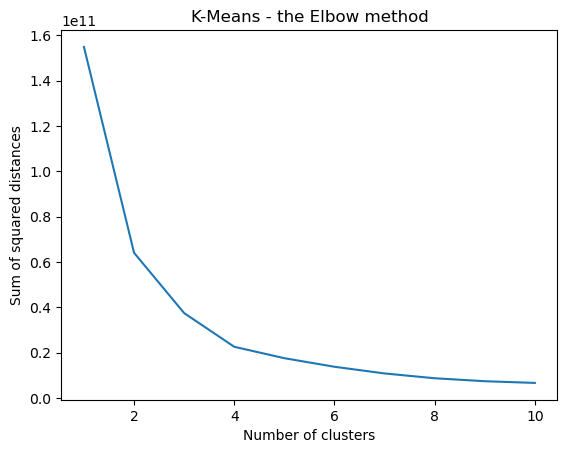

In [246]:
# ELBOW
sum_sqrd = []
for i in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters = i, \
                    init = 'k-means++', \
                    random_state = 42)
    kmeans.fit(X)
    sum_sqrd.append(kmeans.inertia_) # inertia_: Sum of squared distances of samples to their closest cluster center.
plt.plot(range(1, 11), sum_sqrd)
plt.title('K-Means - the Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

In [1]:
kmeans = KMeans(n_clusters = 8, \
                    init = 'k-means++', \
                    random_state = 42, verbose=1)
kmeans.fit(X)
# clf = AffinityPropagation(verbose=1).fit(X, Y)

NameError: name 'KMeans' is not defined

In [ ]:
preds = clf.predict(X_test)
preds[preds != 0] = 1
print(np.sum(preds) / len(preds))
results = pd.DataFrame(columns=['data_id', 'prediction'])
results['data_id'] = list(message_ids)
results['prediction'] = list(preds)
results.to_csv('results13.csv', index=False)

NameError: name 'clf' is not defined